Fracta Coding Challenge - Feb. 2023

In this hypothetical scenario, we’re given some dummy client data which closely follows what we typically see in the real world. Your task will be to clean and do some basic preprocessing on this data, as well as provide some insight into how the data are structured (wrangling + EDA). If you like, you can also extend the analysis to propose some potential modeling ideas that might be effective given what you have observed in the raw data.
Throughout the assignment, make sure to provide commentary explaining your thought process/decisions and that your code is clean and easy to understand.

In [1]:
# import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#### Data Wrangling

The client has provided a pipe file (GM2022_assets.csv) which contains the data describing the actual pipes themselves, and a break file (WO_EXPORT.csv) which contains the data describing past breakages that occurred throughout the pipe network. By the end, we should have two files structured as such:

In [2]:
# Read csv file 
df_asset = pd.read_csv("GM2022_assets.csv")
df_export = pd.read_csv("WO_EXPORT.csv")


In [3]:
df_asset

,GIS_ASSET_WMID,PIPE_MATERIAL,INSTALLATI_YR,Shape_LENGTH,PIPE_DIAMETER,IN_USE,SOURCE,soil_ph,mean_low_temp,soil_moisture_index
0,WM09952-D,DUC(K),S63.12,24.618317,10.0,True,ASBUILT,7.607464,4.924143,6.355882
1,WM02595-P,CIP,S29.7,514.015780,10.0,True,RECORDS,7.998868,5.738295,7.589341
2,WM04638-C,CIP,S11.1,447.747983,6.0,True,RECORDS,8.278671,5.193168,5.677802
3,WM02974-D,DUC(G),S55.2,120.438646,14.0,True,RECORDS,6.409756,6.154922,3.547069
4,WM08449-D,DUC(K),H28.9,0.018670,10.0,True,ASBUILT,7.114687,8.418888,4.167609
...,...,...,...,...,...,...,...,...,...,...
9871,WM09297-A,ACON,S53.12,84.266141,10.0,True,GIS_MERGE,6.858628,8.370945,6.781714
9872,WM07843-A,ACON,S27.6,127.572404,8.0,True,RECORDS,6.958252,8.630475,7.928986
9873,WM12298-P,PVC,H14.7,95.355771,6.0,True,ASBUILT,7.292174,5.555883,2.668141
9874,WM05658-A,ACON,T7.2,17.395419,4.0,True,GIS_MERGE,8.405997,7.915247,7.667133


All null values can be left as-is therefore just check which columns have empty data.

In [4]:
df_asset.isnull().values.sum().sum()

587

In [5]:
df_asset.isnull().any()

GIS_ASSET_WMID         False
PIPE_MATERIAL          False
INSTALLATI_YR           True
Shape_LENGTH           False
PIPE_DIAMETER           True
IN_USE                 False
SOURCE                 False
soil_ph                False
mean_low_temp          False
soil_moisture_index    False
dtype: bool

Column names should follow the convention exactly, or they won’t be interpreted by the model properly. Therefore before any steps change columns names and leave extra unnecessary columns in the data while keeping required ones present. In fact, it may be helpful later to leave useful information in the dataset even if not explicitly required.

In [6]:
# Column names modifiboxion
df_pipe_null = df_asset.rename(
    columns = {
        'GIS_ASSET_WMID' : 'native_pipe_id',
        'PIPE_MATERIAL' : 'material',
        'INSTALLATI_YR' : 'install_yr',
        'Shape_LENGTH' : 'length',
        'PIPE_DIAMETER' : 'diameter',
        'IN_USE' : 'abandoned',
        'SOURCE' : 'source',
        'soil_ph' : 'soil_ph',
        'mean_low_temp' : 'mean_low_temp',
        'soil_moisture_index' : 'soil_moisture_index'
            }
    )

# Creating asset_id which is unique ID set by us
df_pipe_null['asset_id'] = df_pipe_null.index

df_pipe_null = df_pipe_null[
    [
        'native_pipe_id',
        'asset_id',
        'material',
        'install_yr',
        'length',
        'diameter',
        'abandoned',
        'source',
        'soil_ph',
        'mean_low_temp',
        'soil_moisture_index'
        ]
    ]


In [7]:
# Change pipe database year of installation in desirable format
# Create a boolean to select rows that match the condition

Tcond = (df_pipe_null['install_yr'].str.startswith('T')) & \
    (df_pipe_null['install_yr'].str[1:3].astype(float) >= 12) & \
    (df_pipe_null['install_yr'].str[1:3].astype(float) < 26)
    
Scond = (df_pipe_null['install_yr'].str.startswith('S')) & \
    (df_pipe_null['install_yr'].str[1:3].astype(float) >= 26) & \
    (df_pipe_null['install_yr'].str[1:3].astype(float) < 89)
    
Hcond_l = (df_pipe_null['install_yr'].str.startswith('H')) & \
    (df_pipe_null['install_yr'].str[1:3].astype(float) > 89)
    
Hcond_u = (df_pipe_null['install_yr'].str.startswith('H')) & \
    (df_pipe_null['install_yr'].str[1:3].astype(float) >= 0) & \
    (df_pipe_null['install_yr'].str[1:3].astype(float) < 19)

Rcond = (df_pipe_null['install_yr'].str.startswith('R')) & \
    (df_pipe_null['install_yr'].str[1:3].astype(float) >= 19)
    
    
# Use the boolean to select the rows that match the condition and replace the string value
df_pipe_null.loc[Tcond, 'install_yr'] = '19' + df_pipe_null['install_yr'].str[1:3]
df_pipe_null.loc[Scond, 'install_yr'] = '19' + df_pipe_null['install_yr'].str[1:3]

df_pipe_null.loc[Hcond_l, 'install_yr'] = '19' + df_pipe_null['install_yr'].str[1:3]
df_pipe_null.loc[Hcond_u, 'install_yr'] = '20' + df_pipe_null['install_yr'].str[1:3]

df_pipe_null.loc[Rcond, 'install_yr'] = '20' + df_pipe_null['install_yr'].str[1:3]

# convert Column1 to string data type
df_pipe_null['install_yr'] = df_pipe_null['install_yr'].astype(str)

# Change leftover into NaN where string starts with a letter
df_pipe_null.loc[~df_pipe_null['install_yr'].str[0].str.isnumeric(), 'install_yr'] = pd.np.nan


<ipython-input-7-b6c088f58509>:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


In [8]:
np.unique(df_pipe_null['material'])

array(['ACON', 'CIP', 'DUC(G)', 'DUC(K)', 'PVC', 'STP', 'STW'],
      dtype=object)

In [9]:
# pipe material consolidated into the categories listed
df_pipe_null['material'] = df_pipe_null['material'].replace({
    'ACON': 'AC',
    'CIP': 'CAS',
    'DUC(G)': 'DIP',
    'DUC(K)': 'DIP',
    'STP': 'SP',
    'STW': 'SP'
})

In [10]:
df_pipe_null

,native_pipe_id,asset_id,material,install_yr,length,diameter,abandoned,source,soil_ph,mean_low_temp,soil_moisture_index
0,WM09952-D,0,DIP,1963,24.618317,10.0,True,ASBUILT,7.607464,4.924143,6.355882
1,WM02595-P,1,CAS,1929,514.015780,10.0,True,RECORDS,7.998868,5.738295,7.589341
2,WM04638-C,2,CAS,NaN,447.747983,6.0,True,RECORDS,8.278671,5.193168,5.677802
3,WM02974-D,3,DIP,1955,120.438646,14.0,True,RECORDS,6.409756,6.154922,3.547069
4,WM08449-D,4,DIP,NaN,0.018670,10.0,True,ASBUILT,7.114687,8.418888,4.167609
...,...,...,...,...,...,...,...,...,...,...,...
9871,WM09297-A,9871,AC,1953,84.266141,10.0,True,GIS_MERGE,6.858628,8.370945,6.781714
9872,WM07843-A,9872,AC,1927,127.572404,8.0,True,RECORDS,6.958252,8.630475,7.928986
9873,WM12298-P,9873,PVC,2014,95.355771,6.0,True,ASBUILT,7.292174,5.555883,2.668141
9874,WM05658-A,9874,AC,NaN,17.395419,4.0,True,GIS_MERGE,8.405997,7.915247,7.667133


In [11]:
# Convert Column1 to string data type
df_pipe_null['install_yr'] = df_pipe_null['install_yr'].astype(str)

# Only need year
df_pipe_null['install_yr'] = pd.to_datetime(df_pipe_null['install_yr'],errors='coerce')
df_pipe_null['install_yr'] = df_pipe_null['install_yr'].dt.year.fillna(0).astype(int)

In [12]:
df_pipe_null

,native_pipe_id,asset_id,material,install_yr,length,diameter,abandoned,source,soil_ph,mean_low_temp,soil_moisture_index
0,WM09952-D,0,DIP,1963,24.618317,10.0,True,ASBUILT,7.607464,4.924143,6.355882
1,WM02595-P,1,CAS,1929,514.015780,10.0,True,RECORDS,7.998868,5.738295,7.589341
2,WM04638-C,2,CAS,0,447.747983,6.0,True,RECORDS,8.278671,5.193168,5.677802
3,WM02974-D,3,DIP,1955,120.438646,14.0,True,RECORDS,6.409756,6.154922,3.547069
4,WM08449-D,4,DIP,0,0.018670,10.0,True,ASBUILT,7.114687,8.418888,4.167609
...,...,...,...,...,...,...,...,...,...,...,...
9871,WM09297-A,9871,AC,1953,84.266141,10.0,True,GIS_MERGE,6.858628,8.370945,6.781714
9872,WM07843-A,9872,AC,1927,127.572404,8.0,True,RECORDS,6.958252,8.630475,7.928986
9873,WM12298-P,9873,PVC,2014,95.355771,6.0,True,ASBUILT,7.292174,5.555883,2.668141
9874,WM05658-A,9874,AC,0,17.395419,4.0,True,GIS_MERGE,8.405997,7.915247,7.667133


In [13]:
# Method to see the summary statistics for numerical columns
df_pipe_null.describe()

,asset_id,install_yr,length,diameter,soil_ph,mean_low_temp,soil_moisture_index
count,9876.000000,9876.000000,9876.000000,9556.000000,9876.000000,9876.000000,9876.000000
mean,4937.500000,893.420514,200.841010,21.287149,6.999502,6.176641,4.996608
std,2851.099963,973.380850,198.985234,110.647651,0.792028,1.627037,2.246035
min,0.000000,0.000000,0.005697,0.000000,4.070939,0.662405,0.781647
25%,2468.750000,0.000000,57.972311,6.000000,6.461025,5.088890,2.979781
50%,4937.500000,0.000000,142.213713,8.000000,7.001113,6.361409,4.362194
75%,7406.250000,1944.000000,276.245390,10.000000,7.545403,7.453072,7.007298
max,9875.000000,2018.000000,1865.926498,999.000000,10.004537,9.196019,11.212620


In [14]:
df_pipe_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   native_pipe_id       9876 non-null   object 
 1   asset_id             9876 non-null   int64  
 2   material             9876 non-null   object 
 3   install_yr           9876 non-null   int64  
 4   length               9876 non-null   float64
 5   diameter             9556 non-null   float64
 6   abandoned            9876 non-null   bool   
 7   source               9876 non-null   object 
 8   soil_ph              9876 non-null   float64
 9   mean_low_temp        9876 non-null   float64
 10  soil_moisture_index  9876 non-null   float64
dtypes: bool(1), float64(5), int64(2), object(3)
memory usage: 781.3+ KB


In [15]:
df_export

,WO_ASSET,BREAK_TYPE,RESULT,SOURCE,RMINFO,WO_DATEINC,RECORD_DATE
0,WM02656-C,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20020912.0,20221114
1,WM04742-P,CONTRACTOR HIT,Resolved,RECORD,1,20210618.0,20221114
2,WM00040-C,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20130610.0,20221114
3,WM12614-C,"PINHOLE >1""",Resolved,WORKORDER,0,20080521.0,20221114
4,WM04879-A,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20150425.0,20221114
...,...,...,...,...,...,...,...
335,WM11821-A,NaN,Resolved,WORKORDER,0,20140504.0,20221114
336,WM09505-C,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20020210.0,20221114
337,WM11821-A,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20191017.0,20221114
338,WM11821-A,"PINHOLE <=1""",Resolved,RECORD,1,20141017.0,20221114


In [16]:
df_export.isnull().values.sum().sum()

36

In [17]:
df_export.isnull().any()

WO_ASSET       False
BREAK_TYPE      True
RESULT         False
SOURCE         False
RMINFO         False
WO_DATEINC      True
RECORD_DATE    False
dtype: bool

In [18]:
# Column names modifiboxion
df_break_null = df_export.rename(
    columns = {
        'WO_ASSET' : 'native_pipe_id',
        'BREAK_TYPE' : 'break_type',
        'RESULT' : 'result',
        'SOURCE' : 'source',
        'RMINFO' : 'rminfo',
        'WO_DATEINC' : 'wo_dateinc',
        'RECORD_DATE' : 'break_date'
            }
    )

# Creating asset_id by join pipe data
df_break_null['asset_id'] = df_break_null.index

df_break_null = df_break_null[
    [
        'native_pipe_id',
        'asset_id',
        'break_date',
        'break_type',
        'result',
        'source',
        'rminfo',
        'wo_dateinc'
        ]
    ]

In [19]:
# Convert Column1 to string data type
df_break_null['break_date'] = df_break_null['break_date'].astype(str)

# Only need year
df_break_null['break_date'] = pd.to_datetime(df_break_null['break_date'].str[0:4])
df_break_null['break_date'] = df_break_null['break_date'].dt.year


In [20]:
df_break_null

,native_pipe_id,asset_id,break_date,break_type,result,source,rminfo,wo_dateinc
0,WM02656-C,0,2022,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20020912.0
1,WM04742-P,1,2022,CONTRACTOR HIT,Resolved,RECORD,1,20210618.0
2,WM00040-C,2,2022,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20130610.0
3,WM12614-C,3,2022,"PINHOLE >1""",Resolved,WORKORDER,0,20080521.0
4,WM04879-A,4,2022,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20150425.0
...,...,...,...,...,...,...,...,...
335,WM11821-A,335,2022,NaN,Resolved,WORKORDER,0,20140504.0
336,WM09505-C,336,2022,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20020210.0
337,WM11821-A,337,2022,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20191017.0
338,WM11821-A,338,2022,"PINHOLE <=1""",Resolved,RECORD,1,20141017.0


In [21]:
# Method to see the summary statistics for numerical columns
df_break_null.describe()

,asset_id,break_date,rminfo,wo_dateinc
count,340.000000,340.0,340.000000,3.110000e+02
mean,169.500000,2022.0,0.308824,2.010552e+07
std,98.293777,0.0,0.462689,6.088113e+04
min,0.000000,2022.0,0.000000,2.001011e+07
25%,84.750000,2022.0,0.000000,2.005086e+07
50%,169.500000,2022.0,0.000000,2.011022e+07
75%,254.250000,2022.0,1.000000,2.016022e+07
max,339.000000,2022.0,1.000000,2.021120e+07


In [22]:
df_break_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   native_pipe_id  340 non-null    object 
 1   asset_id        340 non-null    int64  
 2   break_date      340 non-null    int64  
 3   break_type      333 non-null    object 
 4   result          340 non-null    object 
 5   source          340 non-null    object 
 6   rminfo          340 non-null    int64  
 7   wo_dateinc      311 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 21.4+ KB


In [23]:
# Saving dataframes to csv file
df_pipe_null.to_csv("Pipe.csv", index=False)
df_break_null.to_csv("Break.csv", index=False)

#### Data Visualization

In [24]:
# Exclude null data when 
df_pipe = df_pipe_null.dropna()
df_break = df_break_null.dropna()


In [25]:
df_pipe

,native_pipe_id,asset_id,material,install_yr,length,diameter,abandoned,source,soil_ph,mean_low_temp,soil_moisture_index
0,WM09952-D,0,DIP,1963,24.618317,10.0,True,ASBUILT,7.607464,4.924143,6.355882
1,WM02595-P,1,CAS,1929,514.015780,10.0,True,RECORDS,7.998868,5.738295,7.589341
2,WM04638-C,2,CAS,0,447.747983,6.0,True,RECORDS,8.278671,5.193168,5.677802
3,WM02974-D,3,DIP,1955,120.438646,14.0,True,RECORDS,6.409756,6.154922,3.547069
4,WM08449-D,4,DIP,0,0.018670,10.0,True,ASBUILT,7.114687,8.418888,4.167609
...,...,...,...,...,...,...,...,...,...,...,...
9871,WM09297-A,9871,AC,1953,84.266141,10.0,True,GIS_MERGE,6.858628,8.370945,6.781714
9872,WM07843-A,9872,AC,1927,127.572404,8.0,True,RECORDS,6.958252,8.630475,7.928986
9873,WM12298-P,9873,PVC,2014,95.355771,6.0,True,ASBUILT,7.292174,5.555883,2.668141
9874,WM05658-A,9874,AC,0,17.395419,4.0,True,GIS_MERGE,8.405997,7.915247,7.667133


In [26]:
df_break

,native_pipe_id,asset_id,break_date,break_type,result,source,rminfo,wo_dateinc
0,WM02656-C,0,2022,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20020912.0
1,WM04742-P,1,2022,CONTRACTOR HIT,Resolved,RECORD,1,20210618.0
2,WM00040-C,2,2022,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20130610.0
3,WM12614-C,3,2022,"PINHOLE >1""",Resolved,WORKORDER,0,20080521.0
4,WM04879-A,4,2022,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20150425.0
...,...,...,...,...,...,...,...,...
334,WM10080-C,334,2022,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20150101.0
336,WM09505-C,336,2022,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20020210.0
337,WM11821-A,337,2022,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20191017.0
338,WM11821-A,338,2022,"PINHOLE <=1""",Resolved,RECORD,1,20141017.0


In [27]:
# Not going to include breaks that aren't due to natural causes in the analysis
np.unique(df_break['break_type'])


array(['CIRCUMFERENCE BREAK', 'CONTRACTOR HIT', 'JOINT FAILURE',
       'PINHOLE <=1"', 'PINHOLE >1"', 'UNKNOWN'], dtype=object)

In [28]:
# Therefore, exclude break caused by contractor hit
df_break = df_break[df_break.break_type != 'CONTRACTOR HIT']

In [29]:
# create a list of words to search for
break_pipe_id = np.unique(df_break['native_pipe_id'])

# create a new column with 0s and 1s based on whether search words are present
df_pipe.loc[:, 'break'] = df_pipe['native_pipe_id'].apply(lambda x: 1 if any(word in x for word in break_pipe_id) else 0)

/Users/wook/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wook/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


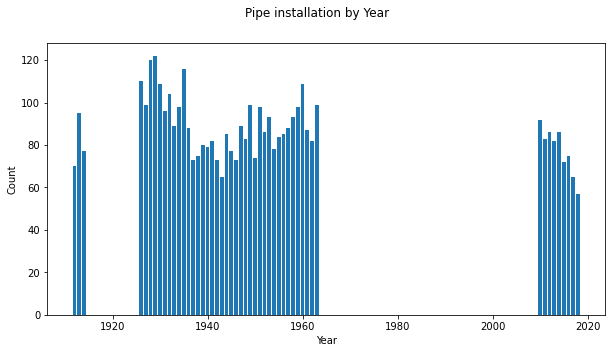

In [30]:
counts = df_pipe['install_yr'].value_counts()

# filter out the rows where the count is 0
counts = counts.tail(-1) 

# sort the data by year to ensure that the timeline is displayed in chronological order
counts = counts.sort_index()

plt.figure(figsize=(10, 5))
plt.bar(counts.index, counts.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.suptitle("Pipe installation by Year")
plt.show()

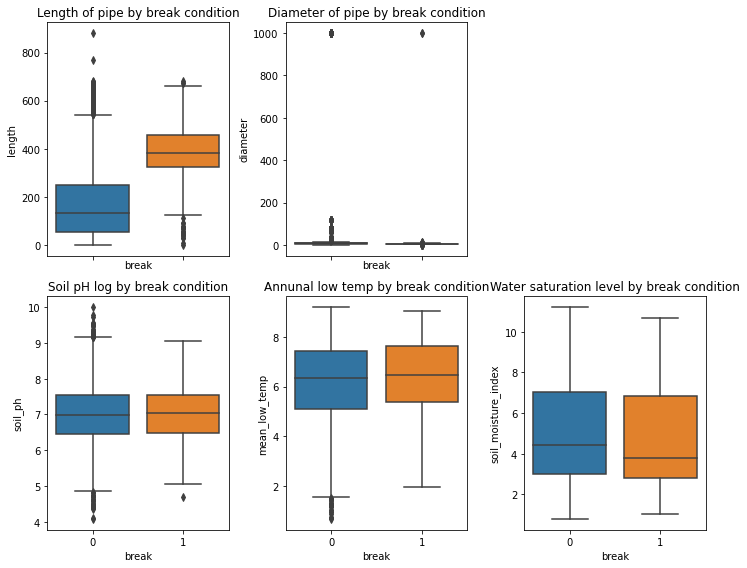

In [31]:
# create subplot grid with 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 8), sharex=True)

# create boxplot of length by break condition
sns.boxplot(x="break", y="length", data=df_pipe, ax=axs[0, 0])

# create boxplot of diameter by break condition
sns.boxplot(x="break", y="diameter", data=df_pipe, ax=axs[0, 1])

# create boxplot of soild ph logs by break condition
sns.boxplot(x="break",y="soil_ph", data=df_pipe, ax=axs[1, 0])

# create boxplot of annual mean low temp by break condition
sns.boxplot(x="break", y="mean_low_temp", data=df_pipe, ax=axs[1, 1])

# create boxplot of annual mean low temp by break condition
sns.boxplot(x="break", y="soil_moisture_index", data=df_pipe, ax=axs[1, 2])


# set subplot titles
axs[0, 0].set_title("Length of pipe by break condition")
axs[0, 1].set_title("Diameter of pipe by break condition")
axs[1, 0].set_title("Soil pH log by break condition")
axs[1, 1].set_title("Annunal low temp by break condition")
axs[1, 2].set_title("Water saturation level by break condition")

# adjust subplot spacing
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# empty subplot at position (0, 2)
axs[0, 2].axis('off')

# adjust subplot spacing
plt.tight_layout()

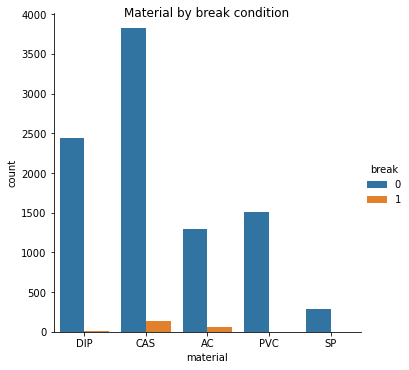

In [32]:
# create catplot of material by break condition
sns.catplot(x="material",hue="break",kind="count", data=df_pipe)

plt.suptitle('Material by break condition', fontsize=12)

plt.show()

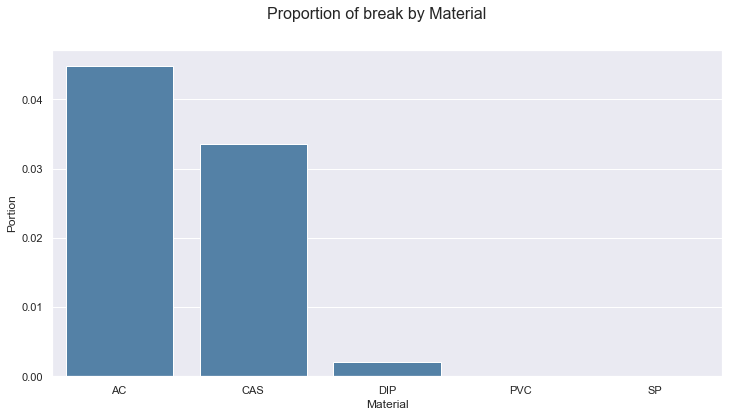

In [33]:
counts = df_pipe.groupby('material')['break'].value_counts(normalize=True).unstack()
counts = counts.sort_values(by=1, ascending=False) # sort by portion of 1

sns.set(style="darkgrid")

plt.figure(figsize=(12, 6))

ax = sns.barplot(x=counts.index, y=counts[1]/counts.sum(axis=1), color='steelblue')

ax.set(xlabel='Material', ylabel='Portion')

plt.suptitle('Proportion of break by Material', fontsize=16)

plt.show()

In [34]:
df_break

,native_pipe_id,asset_id,break_date,break_type,result,source,rminfo,wo_dateinc
0,WM02656-C,0,2022,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20020912.0
2,WM00040-C,2,2022,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20130610.0
3,WM12614-C,3,2022,"PINHOLE >1""",Resolved,WORKORDER,0,20080521.0
4,WM04879-A,4,2022,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20150425.0
6,WM10877-C,6,2022,JOINT FAILURE,Resolved,WORKORDER,0,20171025.0
...,...,...,...,...,...,...,...,...
334,WM10080-C,334,2022,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20150101.0
336,WM09505-C,336,2022,CIRCUMFERENCE BREAK,Resolved,RECORD,1,20020210.0
337,WM11821-A,337,2022,CIRCUMFERENCE BREAK,Resolved,WORKORDER,0,20191017.0
338,WM11821-A,338,2022,"PINHOLE <=1""",Resolved,RECORD,1,20141017.0


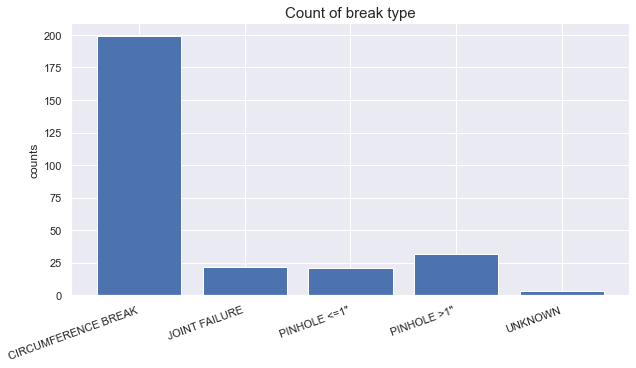

In [35]:
counts = df_break['break_type'].value_counts()

# sort the data by year to ensure that the timeline is displayed in chronological order
counts = counts.sort_index()

plt.figure(figsize=(10, 5))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=20, ha='right')
plt.ylabel("counts")
plt.title("Count of break type",fontsize = 15)
plt.show()

#### Exploratory Data Analysis

In [36]:
# Set features
Y = df_pipe['break']
X = df_pipe[['material','install_yr','length','diameter','abandoned','soil_ph','mean_low_temp','soil_moisture_index']]

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9556 entries, 0 to 9875
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   material             9556 non-null   object 
 1   install_yr           9556 non-null   int64  
 2   length               9556 non-null   float64
 3   diameter             9556 non-null   float64
 4   abandoned            9556 non-null   bool   
 5   soil_ph              9556 non-null   float64
 6   mean_low_temp        9556 non-null   float64
 7   soil_moisture_index  9556 non-null   float64
dtypes: bool(1), float64(5), int64(1), object(1)
memory usage: 864.6+ KB


In [38]:
# Create label encoder object
le = LabelEncoder()

# Encode categorical variables
X.loc[:,'material'] = le.fit_transform(X.loc[:,'material'])
X.loc[:,'abandoned'] = le.fit_transform(X.loc[:,'abandoned'])

# convert float columns to integer
X.loc[:,['length', 'diameter', 'soil_ph','mean_low_temp','soil_moisture_index']] = X.loc[:,['length', 'diameter', 'soil_ph','mean_low_temp','soil_moisture_index']].astype(int)

X = X.astype(int)

/Users/wook/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wook/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:>

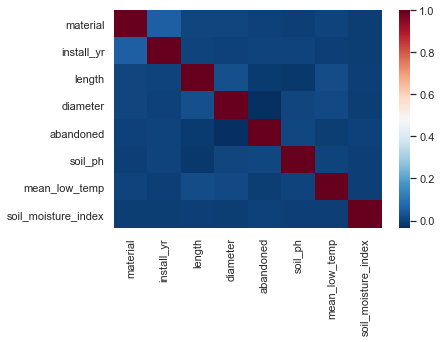

In [39]:
sns.heatmap(X.corr(), cmap='RdBu_r')

#### Data Modeling

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=777)

In [41]:
# Train logistic regression on full data set
lm = LogisticRegression(penalty='l2', max_iter=1000).fit(X,Y)
preds_full = pd.Series(lm.predict_proba(X)[:,1])
predsdf = pd.concat([df_pipe, preds_full], axis=1).rename(columns={0:'pred_lr'})

In [42]:
# Feature coefficients

coefdic = {}

keys = []
values = []

for num, feature in enumerate(X.columns):
    keys.append(feature)
    values.append(round(lm.coef_[0][num],2))
    
for key, value in zip(keys, values):
    coefdic[key] = value


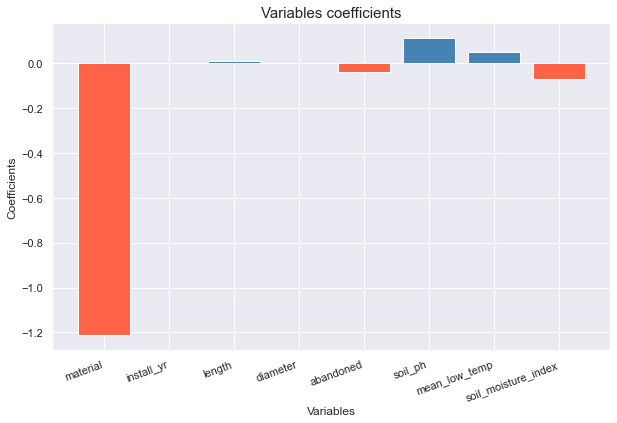

In [43]:
plt.figure(figsize=(10, 6))

col = []


for value in coefdic.values():
    if value < 0 :
        col.append("tomato")
    else:
        col.append("steelblue")

plt.bar(range(len(coefdic)), list(coefdic.values()), align='center', color=col)
plt.xticks(range(len(coefdic)), list(coefdic.keys()))
plt.xticks(rotation=20, ha='right')
plt.xlabel("Variables")
plt.ylabel("Coefficients")
plt.title("Variables coefficients",fontsize=15)
plt.show()

In [44]:
colList = ['native_pipe_id', 'material', 'install_yr', 'length',
       'diameter', 'abandoned', 'soil_ph', 'mean_low_temp',
       'soil_moisture_index', 'break', "pred_lr"]
predsdf[colList].sort_values('pred_lr', ascending=False).head(10)

,native_pipe_id,material,install_yr,length,diameter,abandoned,soil_ph,mean_low_temp,soil_moisture_index,break,pred_lr
8961,WM14631-C,PVC,1957.0,236.428169,10.0,True,6.964844,3.836721,2.729378,0.0,0.551718
7328,WM12984-D,DIP,1929.0,57.884429,6.0,True,6.847723,5.995708,7.322059,0.0,0.530952
1800,WM14356-A,AC,1944.0,103.390602,14.0,True,6.591471,6.625883,7.571424,0.0,0.523262
247,WM03328-C,CAS,0.0,182.865838,6.0,True,7.945735,8.332299,8.632653,1.0,0.514816
9284,WM08074-C,CAS,1927.0,262.745033,6.0,True,6.774148,4.073436,6.382546,0.0,0.513396
2680,WM12112-D,DIP,0.0,38.786585,14.0,True,6.931082,5.255096,5.091817,0.0,0.487334
4822,WM12887-A,AC,0.0,89.024308,8.0,True,6.466961,7.695365,2.922205,0.0,0.484989
6641,WM00934-C,CAS,1913.0,266.500986,10.0,True,7.248035,3.647159,7.934724,0.0,0.481463
8015,WM01525-A,AC,0.0,41.090969,4.0,True,6.341119,6.885398,7.165184,0.0,0.479187
6186,WM07131-A,AC,0.0,51.836428,4.0,True,6.597634,4.279691,6.882407,0.0,0.475388


In [45]:
predsdf[colList][predsdf['break']==1].sort_values('pred_lr', ascending=True).head(10)

,native_pipe_id,material,install_yr,length,diameter,abandoned,soil_ph,mean_low_temp,soil_moisture_index,break,pred_lr
7735,WM07925-C,CAS,1938.0,341.922877,4.0,True,7.223725,3.522952,2.333428,1.0,0.000047
8677,WM12435-C,CAS,0.0,390.788418,8.0,True,7.041410,5.444551,2.744600,1.0,0.000259
7666,WM10774-C,CAS,0.0,551.882703,4.0,True,7.051133,7.757354,6.575279,1.0,0.000279
4175,WM04101-C,CAS,0.0,380.861603,4.0,True,7.474517,6.480270,3.890663,1.0,0.000281
5477,WM00417-C,CAS,0.0,507.880131,4.0,True,7.925129,7.488789,9.390701,1.0,0.000303
3590,WM12405-C,CAS,0.0,111.957716,4.0,True,7.433835,7.591775,6.324243,1.0,0.000304
6232,WM11849-C,CAS,1927.0,278.042274,4.0,True,6.459356,8.713442,3.290043,1.0,0.000330
3219,WM09418-C,CAS,1932.0,417.751988,4.0,True,6.892250,8.157292,2.722086,1.0,0.000345
5507,WM06867-C,CAS,0.0,69.101052,6.0,True,7.557825,7.899566,2.011464,1.0,0.000382
2992,WM13320-A,AC,1930.0,442.263561,6.0,True,7.154601,6.818700,2.571242,1.0,0.000473
